# Network Visualisation of Singapore's Public Bus Transport System

First, to obtain the data set, we need to make API calls using the one provided for LTA's DataMall. 

In [1]:
import requests

In [ ]:
api_key = 'your_API_key'
base_url = 'the_URL_to_make_API_calls_on'

In [ ]:
headers = {
    'AccountKey' : api_key,
    'accept' : 'application/json'
}

In [ ]:
page = 1
all_values = []

while True:
    params = {
        '$skip': (page - 1)*500
    }
    response = requests.get(base_url, 
                            params = params,
                            headers = headers)
    print(f"extracting page {page}")
    values = response.json()['value']
    all_values.extend(values)
    if len(values) != 500:
        break
    page += 1

In [2]:
import pandas as pd 

In [9]:
file_name = pd.DataFrame(all_values)

NameError: name 'all_values' is not defined

In [10]:
# To convert to a csv file if required
file_name.to_csv("file_name.csv", index = False)

NameError: name 'file_name' is not defined

Next, to sort the obtained data set: 
First, import the origin destination trip records,

In [3]:
od_three_months = pd.read_csv('od_three_months.csv',\
                usecols=['ORIGIN_PT_CODE', 'DESTINATION_PT_CODE', 'TOTAL_TRIPS'])

od_three_months['ORIGIN_PT_CODE'] = od_three_months['ORIGIN_PT_CODE'].astype("str").str.zfill(5)
od_three_months['DESTINATION_PT_CODE'] = od_three_months['DESTINATION_PT_CODE'].astype("str").str.zfill(5)

Since we have three months worth of data, it is easier to analyse it when the data is combined as a whole. 
The `.groupby` method takes in an attribute, and groups the data according to the categories, then applies a function to the category. 

In [4]:
od_modified = od_three_months.groupby(['ORIGIN_PT_CODE', 'DESTINATION_PT_CODE'])['TOTAL_TRIPS'].sum()

In [5]:
od_stops = od_modified.reset_index()

In [6]:
od_stops.head()

ORIGIN_PT_CODE DESTINATION_PT_CODE  TOTAL_TRIPS
0          01012               01112         4821
1          01012               01113         3660
2          01012               01121         2306
3          01012               01211         3432
4          01012               01311         5780

Next, import the bus stop data. 

In [7]:
bus_stops = pd.read_csv('bus_stops.csv')
bus_stops["BusStopCode"] = bus_stops["BusStopCode"].astype("str").str.zfill(5)
bus_stops.head(5)

BusStopCode       RoadName          Description  Latitude   Longitude
0       01012    Victoria St  Hotel Grand Pacific  1.296848  103.852536
1       01013    Victoria St      St. Joseph's Ch  1.297710  103.853225
2       01019    Victoria St      Bras Basah Cplx  1.296990  103.853022
3       01029  Nth Bridge Rd         Opp Natl Lib  1.296673  103.854414
4       01039  Nth Bridge Rd           Bugis Cube  1.298208  103.855491

For a more comprehensive overview of where the bus stops are located, we will require the subzone name and region of each bus stop. 

In [8]:
import geopandas as gpd
import numpy as np 
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [9]:
geo_df = gpd.read_file('MP19_SZ_No_Sea/URA_MP19_SUBZONE_NO_SEA_PL.shp')

In [10]:
geo_df_reproj = geo_df.to_crs(3857)

In [11]:
geo_df_reproj.columns

Index(['SUBZONE_NO', 'SUBZONE_N', 'SUBZONE_C', 'CA_IND', 'PLN_AREA_N',
       'PLN_AREA_C', 'REGION_N', 'REGION_C', 'INC_CRC', 'FMEL_UPD_D',
       'geometry'],
      dtype='object')

In [12]:
from shapely.geometry import Point
# Creating a point geometry column
bus_stops['geometry'] = bus_stops.apply(lambda x: Point((x.Longitude, x.Latitude)),
                                       axis = 1)

In [13]:
# Create a GeoDataFrame from the original bus_stops DataFrame
bus_stops_geo = gpd.GeoDataFrame(bus_stops, 
                                 crs = "epsg:4326",
                                 geometry = bus_stops.geometry)
bus_stops_geo_reproj = bus_stops_geo.to_crs(3857)

In [14]:
joined_gdf = gpd.sjoin(bus_stops_geo_reproj, 
                       geo_df_reproj, 
                       how = 'left')

As I will only require the BusStopCode, Subzone Name and Region Name, the geo_df obtained needs to be subset by columns. 
I will also need to convert the subsequent GeoDataFrame into a DataFrame. 

In [15]:
joined_gdf.columns

Index(['BusStopCode', 'RoadName', 'Description', 'Latitude', 'Longitude',
       'geometry', 'index_right', 'SUBZONE_NO', 'SUBZONE_N', 'SUBZONE_C',
       'CA_IND', 'PLN_AREA_N', 'PLN_AREA_C', 'REGION_N', 'REGION_C', 'INC_CRC',
       'FMEL_UPD_D'],
      dtype='object')

In [16]:
# Subset the current joined geo_df to get the columns I need.
required_bus_stops = joined_gdf[['BusStopCode', 'SUBZONE_N', 'PLN_AREA_N', 'REGION_N']]
required_bus_stops.head()

BusStopCode SUBZONE_N     PLN_AREA_N        REGION_N
0       01012  VICTORIA         ROCHOR  CENTRAL REGION
1       01013  VICTORIA         ROCHOR  CENTRAL REGION
2       01019     BUGIS  DOWNTOWN CORE  CENTRAL REGION
3       01029     BUGIS  DOWNTOWN CORE  CENTRAL REGION
4       01039     BUGIS  DOWNTOWN CORE  CENTRAL REGION

In [17]:
bus_stops_df = pd.DataFrame(required_bus_stops)

In [18]:
# To join the 2 datasets we have obtained:
od_stops = pd.merge(od_stops, bus_stops_df,\
                    how = 'left', left_on ='ORIGIN_PT_CODE', right_on = 'BusStopCode')
od_stops = pd.merge(od_stops, bus_stops_df,\
             how = 'left', left_on = 'DESTINATION_PT_CODE', right_on = 'BusStopCode')
od_stops.head(10)

ORIGIN_PT_CODE DESTINATION_PT_CODE  TOTAL_TRIPS BusStopCode_x SUBZONE_N_x  \
0          01012               01112         4821         01012    VICTORIA   
1          01012               01113         3660         01012    VICTORIA   
2          01012               01121         2306         01012    VICTORIA   
3          01012               01211         3432         01012    VICTORIA   
4          01012               01311         5780         01012    VICTORIA   
5          01012               01549           22         01012    VICTORIA   
6          01012               01559           78         01012    VICTORIA   
7          01012               07371          227         01012    VICTORIA   
8          01012               60011          321         01012    VICTORIA   
9          01012               60021          343         01012    VICTORIA   

  PLN_AREA_N_x      REGION_N_x BusStopCode_y    SUBZONE_N_y   PLN_AREA_N_y  \
0       ROCHOR  CENTRAL REGION         01112       VICTORIA         ROCHOR   
1       ROCHOR  CENTRAL REGION         01113          BUGIS  DOWNTOWN CORE   
2       ROCHOR  CENTRAL REGION         01121   ROCHOR CANAL         ROCHOR   
3       ROCHOR  CENTRAL REGION         01211       CRAWFORD        KALLANG   
4       ROCHOR  CENTRAL REGION         01311       LAVENDER        KALLANG   
5       ROCHOR  CENTRAL REGION         01549   KAMPONG GLAM         ROCHOR   
6       ROCHOR  CENTRAL REGION         01559   KAMPONG GLAM         ROCHOR   
7       ROCHOR  CENTRAL REGION         07371       LAVENDER        KALLANG   
8       ROCHOR  CENTRAL REGION         60011  KALLANG BAHRU        KALLANG   
9       ROCHOR  CENTRAL REGION         60021  KALLANG BAHRU        KALLANG   

       REGION_N_y  
0  CENTRAL REGION  
1  CENTRAL REGION  
2  CENTRAL REGION  
3  CENTRAL REGION  
4  CENTRAL REGION  
5  CENTRAL REGION  
6  CENTRAL REGION  
7  CENTRAL REGION  
8  CENTRAL REGION  
9  CENTRAL REGION

In [19]:
# rename the df for easier use
final_df = od_stops

In [20]:
final_df.shape

(372020, 11)

A couple of test cases to visualise how to obtain the general graph object function. 

In [21]:
import seaborn as sns

In [22]:
# TESTCASE 1 
trips = final_df[['PLN_AREA_N_x', 'PLN_AREA_N_y']]\
    .loc[((final_df['REGION_N_x']=='CENTRAL REGION') & (final_df['REGION_N_y']=='CENTRAL REGION'))]\
    .value_counts()

trips

PLN_AREA_N_x      PLN_AREA_N_y    
BUKIT MERAH       BUKIT MERAH         4482
QUEENSTOWN        QUEENSTOWN          3799
GEYLANG           GEYLANG             3209
BUKIT MERAH       QUEENSTOWN          2722
BUKIT TIMAH       BUKIT TIMAH         2437
                                      ... 
SOUTHERN ISLANDS  MUSEUM                 4
NEWTON            ROCHOR                 4
MUSEUM            SOUTHERN ISLANDS       3
BUKIT TIMAH       SOUTHERN ISLANDS       2
NEWTON            STRAITS VIEW           1
Length: 347, dtype: int64

In [23]:
links = pd.DataFrame.from_records(list(trips.index),\
                                 columns = ['start', 'end'])
links['trips'] = trips.values

links.head()

start          end  trips
0  BUKIT MERAH  BUKIT MERAH   4482
1   QUEENSTOWN   QUEENSTOWN   3799
2      GEYLANG      GEYLANG   3209
3  BUKIT MERAH   QUEENSTOWN   2722
4  BUKIT TIMAH  BUKIT TIMAH   2437

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
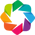

In [24]:
from holoviews import opts, dim
import holoviews as hv

hv.extension('bokeh')
hv.output(size=200)

In [25]:
names = links.start + '/' + links.end
plt.figure(figsize=(12,10))
sns.barplot( x=links.trips[:], y=names[:], orient="h") ; 

In [26]:
pd.pivot_table(links, index='start', values='trips', columns='end')

end               BISHAN  BUKIT MERAH  BUKIT TIMAH  DOWNTOWN CORE  GEYLANG  \
start                                                                        
BISHAN            1222.0        467.0        415.0          380.0    173.0   
BUKIT MERAH        419.0       4482.0        981.0          905.0   1285.0   
BUKIT TIMAH        516.0        602.0       2437.0          409.0    613.0   
DOWNTOWN CORE      368.0       1420.0        473.0          794.0    338.0   
GEYLANG            147.0       1350.0        879.0          641.0   3209.0   
KALLANG            231.0       1260.0        579.0          798.0   1178.0   
MARINA SOUTH         NaN          NaN          NaN           24.0      NaN   
MARINE PARADE       71.0        522.0         16.0          373.0    625.0   
MUSEUM             124.0        326.0        183.0          144.0    182.0   
NEWTON              71.0         95.0        120.0           44.0     39.0   
NOVENA             493.0       1163.0        408.0          462.0    577.0   
ORCHARD            166.0        395.0        176.0          222.0    104.0   
OUTRAM              66.0        543.0        251.0           78.0    183.0   
QUEENSTOWN         213.0       2332.0        889.0          767.0    932.0   
RIVER VALLEY        42.0        228.0        128.0           87.0     36.0   
ROCHOR             131.0        397.0        160.0          176.0    355.0   
SINGAPORE RIVER     79.0        435.0        116.0           84.0    191.0   
SOUTHERN ISLANDS     NaN         35.0          NaN            NaN      NaN   
STRAITS VIEW         NaN          NaN          NaN           19.0      NaN   
TANGLIN             86.0        542.0        792.0          342.0    170.0   
TOA PAYOH          341.0        604.0        294.0          415.0    670.0   

end               KALLANG  MARINA SOUTH  MARINE PARADE  MUSEUM  NEWTON  ...  \
start                                                                   ...   
BISHAN              253.0           NaN           10.0   117.0    73.0  ...   
BUKIT MERAH        1162.0           NaN          318.0   673.0    92.0  ...   
BUKIT TIMAH         446.0           NaN           24.0   137.0    30.0  ...   
DOWNTOWN CORE       505.0          25.0          207.0   154.0    59.0  ...   
GEYLANG            1335.0           NaN          556.0    89.0   128.0  ...   
KALLANG            1384.0           NaN          143.0   131.0    65.0  ...   
MARINA SOUTH          NaN          10.0            NaN     NaN     NaN  ...   
MARINE PARADE       418.0           NaN          423.0    89.0    40.0  ...   
MUSEUM              190.0           NaN          105.0    61.0    37.0  ...   
NEWTON               11.0           NaN            NaN    24.0    26.0  ...   
NOVENA              631.0           NaN           53.0   138.0    65.0  ...   
ORCHARD              73.0           NaN           96.0    87.0    53.0  ...   
OUTRAM              108.0           NaN           23.0    53.0    18.0  ...   
QUEENSTOWN          692.0           NaN          345.0   415.0    47.0  ...   
RIVER VALLEY         43.0           NaN           39.0    48.0     6.0  ...   
ROCHOR              284.0           NaN           64.0    38.0    35.0  ...   
SINGAPORE RIVER      84.0           NaN           28.0    44.0    17.0  ...   
SOUTHERN ISLANDS      NaN           NaN            NaN     4.0     NaN  ...   
STRAITS VIEW          NaN           NaN            NaN     NaN     NaN  ...   
TANGLIN             149.0           NaN           60.0   126.0    26.0  ...   
TOA PAYOH           496.0           NaN           96.0    56.0    30.0  ...   

end               ORCHARD  OUTRAM  QUEENSTOWN  RIVER VALLEY  ROCHOR  \
start                                                                 
BISHAN               99.0    94.0       224.0          92.0   135.0   
BUKIT MERAH         372.0   436.0      2722.0         202.0   616.0   
BUKIT TIMAH         250.0   244.0       962.0         107.0   174.0   
DOWNTOWN CORE       200.0   163.

In [27]:
chord=hv.Chord(links[:60])
chord.opts(node_color='index', edge_color='start',\
          label_index='index', cmap='Category10', edge_cmap='Category10')

:Chord   [start,end]   (trips)

In [28]:
# TESTCASE 2 
areas = ['BUKIT BATOK', 'CLEMENTI', 'JURONG EAST']
trips = final_df[['SUBZONE_N_x', 'SUBZONE_N_y']]\
    .loc[((final_df['PLN_AREA_N_x']=='BUKIT BATOK') & (final_df['PLN_AREA_N_y']=='BUKIT BATOK'))]\
    .value_counts()

trips.head()

SUBZONE_N_x          SUBZONE_N_y        
HILLVIEW             HILLVIEW               235
BUKIT BATOK CENTRAL  BUKIT BATOK CENTRAL    163
HILLVIEW             BUKIT BATOK CENTRAL    134
BUKIT BATOK CENTRAL  HILLVIEW               131
BUKIT BATOK SOUTH    BUKIT BATOK CENTRAL    125
dtype: int64

In [29]:
links = pd.DataFrame.from_records(list(trips.index),\
                                 columns = ['start', 'end'])
links['trips'] = trips.values

links.head()

start                  end  trips
0             HILLVIEW             HILLVIEW    235
1  BUKIT BATOK CENTRAL  BUKIT BATOK CENTRAL    163
2             HILLVIEW  BUKIT BATOK CENTRAL    134
3  BUKIT BATOK CENTRAL             HILLVIEW    131
4    BUKIT BATOK SOUTH  BUKIT BATOK CENTRAL    125

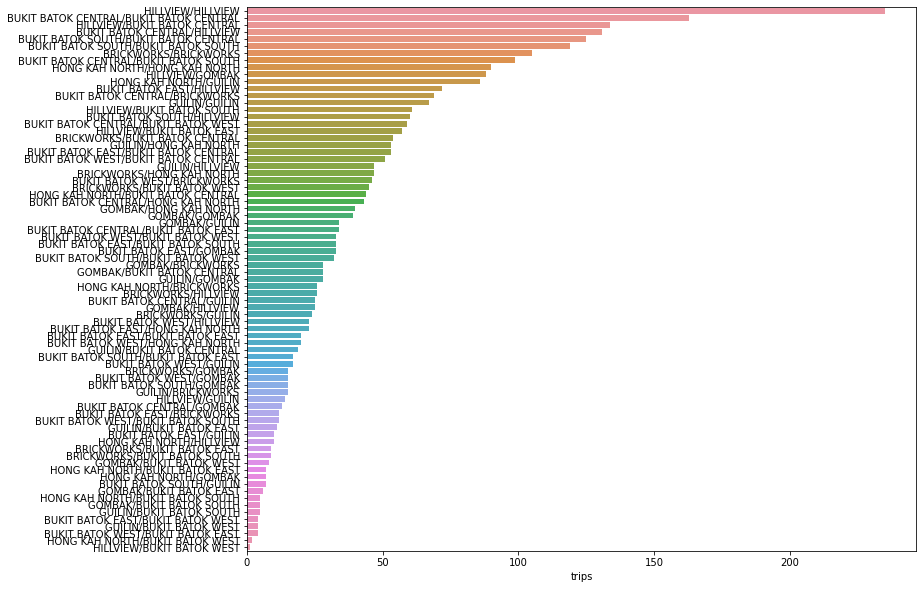

In [30]:
names = links.start + '/' + links.end
plt.figure(figsize=(12,10))
sns.barplot( x=links.trips[:], y=names[:], orient="h") ;

In [31]:
pd.pivot_table(links, index='start', values='trips', columns='end')

end                  BRICKWORKS  BUKIT BATOK CENTRAL  BUKIT BATOK EAST  \
start                                                                    
BRICKWORKS                105.0                 54.0               9.0   
BUKIT BATOK CENTRAL        69.0                163.0              34.0   
BUKIT BATOK EAST           12.0                 53.0              20.0   
BUKIT BATOK SOUTH           NaN                125.0              17.0   
BUKIT BATOK WEST           46.0                 51.0               4.0   
GOMBAK                     28.0                 28.0               6.0   
GUILIN                     15.0                 19.0              11.0   
HILLVIEW                    NaN                134.0              57.0   
HONG KAH NORTH             26.0                 44.0               7.0   

end                  BUKIT BATOK SOUTH  BUKIT BATOK WEST  GOMBAK  GUILIN  \
start                                                                      
BRICKWORKS                         9.0              45.0    15.0    24.0   
BUKIT BATOK CENTRAL               99.0              59.0    13.0    25.0   
BUKIT BATOK EAST                  33.0               4.0    33.0    10.0   
BUKIT BATOK SOUTH                119.0              32.0    15.0     7.0   
BUKIT BATOK WEST                  12.0              33.0    15.0    17.0   
GOMBAK                             5.0               8.0    39.0    34.0   
GUILIN                             5.0               4.0    28.0    67.0   
HILLVIEW                          61.0               1.0    88.0    14.0   
HONG KAH NORTH                     5.0               2.0     7.0    86.0   

end                  HILLVIEW  HONG KAH NORTH  
start                                          
BRICKWORKS               26.0            47.0  
BUKIT BATOK CENTRAL     131.0            43.0  
BUKIT BATOK EAST         72.0            23.0  
BUKIT BATOK SOUTH        60.0             NaN  
BUKIT BATOK WEST         23.0            20.0  
GOMBAK                   25.0            40.0  
GUILIN                   47.0            53.0  
HILLVIEW                235.0             NaN  
HONG KAH NORTH           10.0            90.0

In [32]:
chord=hv.Chord(links[:])
chord.opts(node_color='index', edge_color='start',\
          label_index='index', cmap='Category10', edge_cmap='Category10')

:Chord   [start,end]   (trips)

In [33]:
# TESTCASE 3
trips = final_df[['SUBZONE_N_x', 'SUBZONE_N_y']]\
    .loc[((final_df['PLN_AREA_N_x']=='CLEMENTI') & (final_df['PLN_AREA_N_y']=='CLEMENTI'))]\
    .value_counts()

trips.head()

SUBZONE_N_x       SUBZONE_N_y     
TOH TUCK          TOH TUCK            144
CLEMENTI WEST     CLEMENTI WEST        78
CLEMENTI CENTRAL  CLEMENTI CENTRAL     74
TOH TUCK          CLEMENTI NORTH       71
CLEMENTI NORTH    CLEMENTI NORTH       71
dtype: int64

In [34]:
links = pd.DataFrame.from_records(list(trips.index),\
                                 columns = ['start', 'end'])
links['trips'] = trips.values

links.head()

start               end  trips
0          TOH TUCK          TOH TUCK    144
1     CLEMENTI WEST     CLEMENTI WEST     78
2  CLEMENTI CENTRAL  CLEMENTI CENTRAL     74
3          TOH TUCK    CLEMENTI NORTH     71
4    CLEMENTI NORTH    CLEMENTI NORTH     71

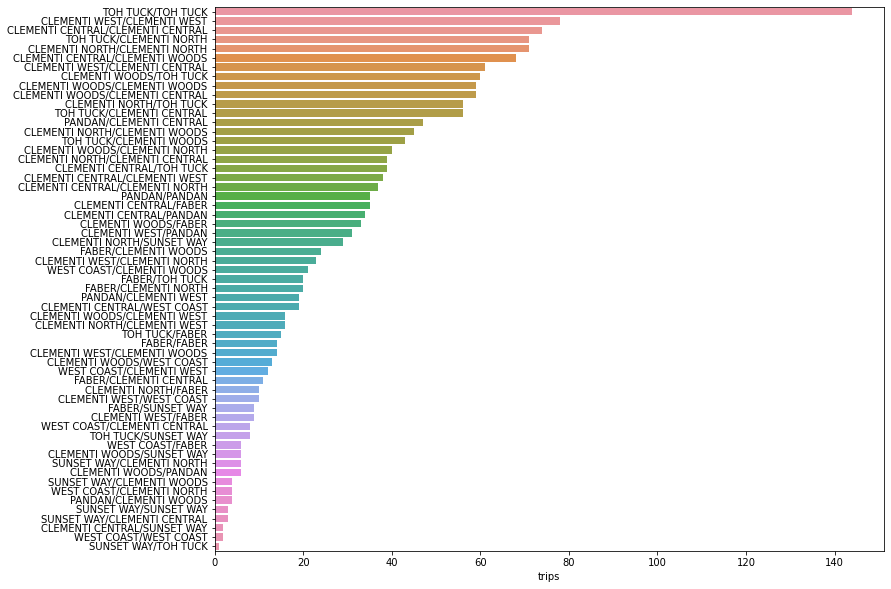

In [35]:
names = links.start + '/' + links.end
plt.figure(figsize=(12,10))
sns.barplot( x=links.trips[:], y=names[:], orient="h") ;

In [36]:
chord=hv.Chord(links[:])
chord.opts(node_color='index', edge_color='start',\
          label_index='index', cmap='Category10', edge_cmap='Category10')

:Chord   [start,end]   (trips)

## Filtering the dataframe
The function `filter_trips()` below allows us to easily filter the data frame we are working on, to obtain a subset of the data set.  

In [37]:
def filter_trips(od_stops,
                 level, # 'SUBZONE', 'PLN_AREA', 'REGION'
                 selected_origin, # ['VICTORIA']
                 selected_dest, # 'all' OR ['CHONG BOON', 'CHONG PANG']
                 min_trips): # 5000
    '''
    Filters the origin-destination dataframe for selected origin-destination pairs
    and for a minimum number of trips.

    Args:
        od_stops: Pandas dataframe of all origin-destination bus stops and trip numbers
        level: Which geospatial level to filter at (subzone, planning area, or region)
        selected_origin: The origin area(s) in the level selected 
        selected_dest: The destination area(s) in the level selected
        min_trips: integer value of the minimum number of trips to be filtered
    Returns:
        What do you return? Pandas dataframe which is filtered
    Raises:
        AssertionError: For incorrect inputs
    '''

    # Check that the level that was passed in is correct
    if level not in ['SUBZONE', 'PLN_AREA', 'REGION']:
        raise AssertionError("Error! Please key in a correct level.")

    # Check that there is some selection
    if len(selected_origin) == 0:
        raise AssertionError("Error! Please select at least one origin.")
    if len(selected_dest) == 0:
        raise AssertionError("Error! Please select at least one destination.")

    # Check that min_trips is at least 1
    if min_trips < 0:
        raise AssertionError("Error! Please key in a positive integer value \
                                to be the minimum number of trips.")
        
    def generate_boolean_mask(df, level, origin_dest, selected):
        if selected == 'all':
            boolean_mask = ~df[f'{level}_N_{origin_dest}'].isin([])
        else:
            boolean_mask = df[f'{level}_N_{origin_dest}'].isin(selected)
        return boolean_mask

    boolean_mask_origin = generate_boolean_mask(od_stops,
                                           level,
                                           "x",
                                           selected_origin)

    boolean_mask_dest = generate_boolean_mask(od_stops,
                                           level,
                                           "y",
                                           selected_dest)

    boolean_mask_mintrips = od_stops['TOTAL_TRIPS'] >= min_trips

    output = od_stops[boolean_mask_origin & boolean_mask_dest & boolean_mask_mintrips].reset_index(drop = True)

    return output

In [38]:
filter_trips(final_df, 'SUBZONE', ['VICTORIA'], ['BUGIS'], 5)

ORIGIN_PT_CODE DESTINATION_PT_CODE  TOTAL_TRIPS BusStopCode_x SUBZONE_N_x  \
0          01012               01113         3660         01012    VICTORIA   
1          01013               01113          617         01013    VICTORIA   
2          07518               01511          440         07518    VICTORIA   
3          07518               01621          411         07518    VICTORIA   
4          07518               01639         1699         07518    VICTORIA   
5          07569               01511          227         07569    VICTORIA   
6          07569               01621          130         07569    VICTORIA   
7          07569               01639          415         07569    VICTORIA   

  PLN_AREA_N_x      REGION_N_x BusStopCode_y SUBZONE_N_y   PLN_AREA_N_y  \
0       ROCHOR  CENTRAL REGION         01113       BUGIS  DOWNTOWN CORE   
1       ROCHOR  CENTRAL REGION         01113       BUGIS  DOWNTOWN CORE   
2       ROCHOR  CENTRAL REGION         01511       BUGIS  DOWNTOWN CORE   
3       ROCHOR  CENTRAL REGION         01621       BUGIS  DOWNTOWN CORE   
4       ROCHOR  CENTRAL REGION         01639       BUGIS  DOWNTOWN CORE   
5       ROCHOR  CENTRAL REGION         01511       BUGIS  DOWNTOWN CORE   
6       ROCHOR  CENTRAL REGION         01621       BUGIS  DOWNTOWN CORE   
7       ROCHOR  CENTRAL REGION         01639       BUGIS  DOWNTOWN CORE   

       REGION_N_y  
0  CENTRAL REGION  
1  CENTRAL REGION  
2  CENTRAL REGION  
3  CENTRAL REGION  
4  CENTRAL REGION  
5  CENTRAL REGION  
6  CENTRAL REGION  
7  CENTRAL REGION

## Formatting the Data:
After obtaining the filtered dataframe, we need to transform the filtered dataframe into one that can be used for visualisation. 

We will only require BusStopCode_x, BusStopCode_y, as well as the origin and destination level that was previously selected. 

In [39]:
def format_df(filtered_df, level):

    cols = ['BusStopCode_x', 'BusStopCode_y', f"{level}_N_x", f"{level}_N_y", 'TOTAL_TRIPS']
    
    required = filtered_df[cols]
    
    output = required.rename(columns = {"BusStopCode_x" : "START", "BusStopCode_y" : "END", "TOTAL_TRIPS" : "WEIGHT"})
    # output['WEIGHT_INV'] = 1/output.WEIGHT
    
    return output

In [40]:
desired_df = format_df(filter_trips(final_df, 'PLN_AREA', ['CLEMENTI'], ['JURONG EAST'], 5), 'PLN_AREA')
desired_df

START    END PLN_AREA_N_x PLN_AREA_N_y  WEIGHT
0    12201  28299     CLEMENTI  JURONG EAST    2376
1    12201  28451     CLEMENTI  JURONG EAST     691
2    12201  28461     CLEMENTI  JURONG EAST     637
3    12201  28491     CLEMENTI  JURONG EAST     372
4    16131  28009     CLEMENTI  JURONG EAST      21
..     ...    ...          ...          ...     ...
988  28709  28211     CLEMENTI  JURONG EAST    2012
989  28709  28319     CLEMENTI  JURONG EAST     334
990  28709  28449     CLEMENTI  JURONG EAST     248
991  28709  28639     CLEMENTI  JURONG EAST     655
992  28709  28649     CLEMENTI  JURONG EAST    1675

[993 rows x 5 columns]

## Visualisation of Data 

In [41]:
import community
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [51]:
G = nx.from_pandas_edgelist(desired_df, 
                           source = "START",
                           target = "END",
                           edge_attr = "WEIGHT")

In [56]:
# Labelling of nodes
for node in G.nodes():
    G.nodes()[node]["label"] = str(node)

In [57]:
G.nodes(data = True)

# Store subzone/planning area/region in nodes, 
# number of trips in edges

NodeDataView({'12201': {'label': '12201'}, '28299': {'label': '28299'}, '28451': {'label': '28451'}, '28461': {'label': '28461'}, '28491': {'label': '28491'}, '16131': {'label': '16131'}, '28009': {'label': '28009'}, '28041': {'label': '28041'}, '28211': {'label': '28211'}, '28319': {'label': '28319'}, '28621': {'label': '28621'}, '28639': {'label': '28639'}, '28649': {'label': '28649'}, '28659': {'label': '28659'}, '16141': {'label': '16141'}, '28449': {'label': '28449'}, '16151': {'label': '16151'}, '17009': {'label': '17009'}, '28051': {'label': '28051'}, '28061': {'label': '28061'}, '28071': {'label': '28071'}, '28081': {'label': '28081'}, '28281': {'label': '28281'}, '17011': {'label': '17011'}, '20121': {'label': '20121'}, '20129': {'label': '20129'}, '20141': {'label': '20141'}, '20151': {'label': '20151'}, '20161': {'label': '20161'}, '20171': {'label': '20171'}, '20189': {'label': '20189'}, '20199': {'label': '20199'}, '20201': {'label': '20201'}, '20211': {'label': '20211'}, 

In [54]:
G.edges()

EdgeView([('12201', '28299'), ('12201', '28451'), ('12201', '28461'), ('12201', '28491'), ('28299', '17151'), ('28299', '17161'), ('28299', '17171'), ('28299', '17181'), ('28299', '17371'), ('28451', '17009'), ('28451', '17121'), ('28451', '17131'), ('28451', '17141'), ('28451', '17151'), ('28451', '17161'), ('28451', '17171'), ('28451', '17181'), ('28451', '17371'), ('28451', '20011'), ('28451', '20021'), ('28451', '20031'), ('28451', '20101'), ('28451', '28011'), ('28451', '28021'), ('28451', '28031'), ('28461', '17009'), ('28461', '17121'), ('28461', '17131'), ('28461', '17141'), ('28461', '17151'), ('28461', '17161'), ('28461', '17171'), ('28461', '17181'), ('28461', '17371'), ('28461', '20011'), ('28461', '20021'), ('28461', '20031'), ('28461', '20101'), ('28461', '28011'), ('28461', '28021'), ('28461', '28031'), ('28491', '17009'), ('28491', '17121'), ('28491', '17131'), ('28491', '17141'), ('28491', '17151'), ('28491', '17161'), ('28491', '17171'), ('28491', '17181'), ('28491', 

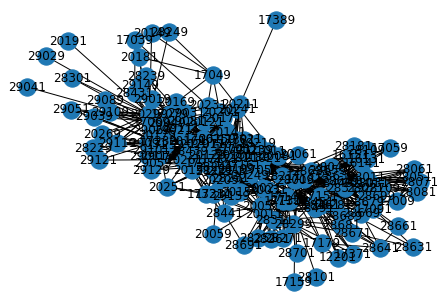

In [59]:
nx.draw(G, with_labels = True)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
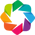

In [5]:
import numpy as np
import pandas as pd
import networkx as nx
from holoviews import opts, dim
import holoviews as hv

hv.extension('bokeh')
hv.output(size=200)

NameError: name 'chordDiagram' is not defined

`pd.DataFrame.from_records()` creates a DataFrame obj from a structured ndarray, seq of tuples/dicts, or DataFrame.

In [ ]:
links = pd.DataFrame.from_records(list(trips.index),\
                                 columns = ['start', 'end'])
links['trips'] = trips.values

links.head()

In [ ]:
names = links.start + '/' + links.end
plt.figure(figsize=(12,10))
sns.barplot( x=links.trips[:], y=names[:], orient="h") ;

In [ ]:
chord=hv.Chord(links[:60])
chord.opts(node_color='index', edge_color='start',\
          label_index='index', cmap='Category10', edge_cmap='Category10')